# Introduction to DEA Burn Cube method <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with specific `DEA Dev Sandbox` environment: HNRS test
* **Products used:** 
[ga_ls8c_nbart_gm_4fyear_2015](http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/),
 [ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
 [ga_s2ab_ard_gm_4fyear_2015](http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/),
 [ga_s2am_ard_3](https://explorer.dev.dea.ga.gov.au/products/ga_s2am_ard_3),
 [ga_s2bm_ard_3](https://explorer.dev.dea.ga.gov.au/products/ga_s2bm_ard_3),
 [DEA Hotsopt](https://hotspots.dea.ga.gov.au/),
 [ga_ls_wo_fq_fyear_3](https://explorer.dev.dea.ga.gov.au/products/ga_ls_wo_fq_fyear_3)
* **Special requirements:** run in the HNRS test DEA dev sandbox environment. Download DEA_Burn_Cube_utils.py file from https://github.com/GeoscienceAustralia/burn-mapping/tree/develop/ardc_historic_burn.
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

## Background
As part of the ARDC Bushfire Data Challenge, this notebook was developed based on the code used for our LS ARD or S2 ARD burnt area product. This notebook calculates burnt pixel by using NBR (Normalized Burn Ratio) distance. It uses both cosine distance, NBR euclidean distance, and NBR change direction for change detection.

## Description
This notebook runs on Landsat 8 or Sentinel-2 data.

We use these with a 4 year GeoMedian from before the fire season and then ARD data from the fire season.

1. load pre-fire season ARD data and pre-fire season GeoMedian data.
2. compute the Outlier layer by calculating the cosine and NBR euclidian distance between ARD data and GeoMedian data.
3. load fire season ARD data and pre-fire season GeoMedian data.
4. detects burnt area by using cosine distance outliers and NBR euclidean distance outliers, and filter result by DEA Hotspots.
5. filter result by DEA WOfS summary.

For further reading on the methods used, see the paper associated with this work: Renzullo et al (2019), Burn extent and severity mapping by spectral anomaly detection in the Landsat data cube.

***

In [1]:
%matplotlib inline

import os
import datacube
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray
import rasterio.features
import rioxarray
import dea_tools
import logging

from dea_tools.plotting import rgb
from dea_tools.datahandling import load_ard
from skimage import morphology 
from scipy import ndimage
from shapely.geometry import shape
from shapely.geometry import Polygon
from datacube.utils.geometry import Geometry, CRS
from datacube.utils.cog import write_cog
from odc.dscache.tools.tiling import parse_gridspec_with_name
from typing import List, Tuple

logger = logging.getLogger(__name__)

Setting up the notebook to access the correct path for the data (using the HNRS test environment in DEA dev sandbox) by setting up the configs

In [2]:
# the normal config
odc_config = {'db_hostname': os.getenv("DB_HOSTNAME"),
              'db_password': os.getenv("ODC_DB_PASSWORD"),
              'db_username': os.getenv("ODC_DB_USERNAME"),
              'db_port': 5432,
              'db_database': os.getenv("ODC_DB_DATABASE")}

#the special config for our multi year geomedian
hnrs_config = {'db_hostname': os.getenv("DB_HOSTNAME"),
               'db_password': os.getenv("HNRS_DC_DB_PASSWORD"),
               'db_username': os.getenv("HNRS_DC_DB_USERNAME"),
               'db_port': 5432,
               'db_database': os.getenv("HNRS_DC_DB_DATABASE")}

# need to set the AWS login so that we can access the data we need
os.environ["AWS_NO_SIGN_REQUEST"] = "Yes"

# this is the interface we load ARD datasets
dc = datacube.Datacube(app="bc_ard", config=odc_config)
# this is how we get the multi year geomedian to use as our pre-fire data
hnrs_dc = datacube.Datacube(app="bc_geomed", config=hnrs_config)

### Analysis parameters
This notebook is set up to run a whole tile area, so from the AU30 grid, select the tile name that you are after e.g. "x32y15"

xy: A string containing the name of the tile you would like to investigate (e.g. "x32y15").

In [3]:
xy = 'x32y16'

# Generate Landsat Burn Cube result

## 1. Loading the pre-fire season data

Now that we have selected our area of interest (tile) we can load it in. To do this we need to get the polygon that we can then feed into `dc.load` and `load_ard`.

In [4]:
def _get_gpgon(
    region_id: str,
) -> Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]:
    """
    Get a geometry that covers the specified region for use with datacube.load().

    Parameters
    ----------
    region_id : str
        The ID of the region to get a geometry for. E.g. x30y29

    Returns
    -------
    Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]
        The geometry object representing the region specified by `region_id` and the corresponding geobox.
    """

    _, gridspec = parse_gridspec_with_name("au-30")

    # gridspec : au-30
    pattern = r"x(\d+)y(\d+)"

    match = re.match(pattern, region_id)

    if match:
        x = int(match.group(1))
        y = int(match.group(2))
    else:
        logger.error(
            "No match found in region id %s.",
            region_id,
        )
        # cannot extract geobox, so we stop here.
        # if we throw exception, it will trigger the Airflow/Argo retry.
        sys.exit(0)

    geobox = gridspec.tile_geobox((x, y))

    # Return the resulting Geometry object
    return datacube.utils.geometry.Geometry(geobox.extent.geom, crs="epsg:3577"), geobox

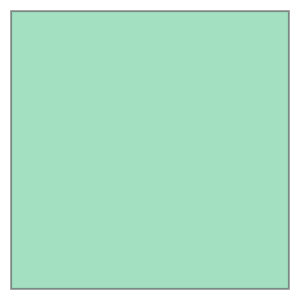

In [5]:
#running the polygon function, and getting a usable polygon out
box = _get_gpgon(xy)
pgon = box[0]
pgon

Load in the 4 years `geomedian`, this is our Pre Fire Data. Use `ga_ls8c_nbart_gm_4fyear_2015` for financial year.

In [6]:
# PRE FIRE DATA
# load in the 4 year geomedian
geomed_ds = hnrs_dc.load(product="ga_ls8c_nbart_gm_4fyear_2015", 
                         measurements=["red", "green", "blue", "nir", "swir1", "swir2"], 
                         geopolygon = pgon, 
                         time=("2016-07-01", "2019-06-30"), #financial year
                         output_crs="EPSG:3577")


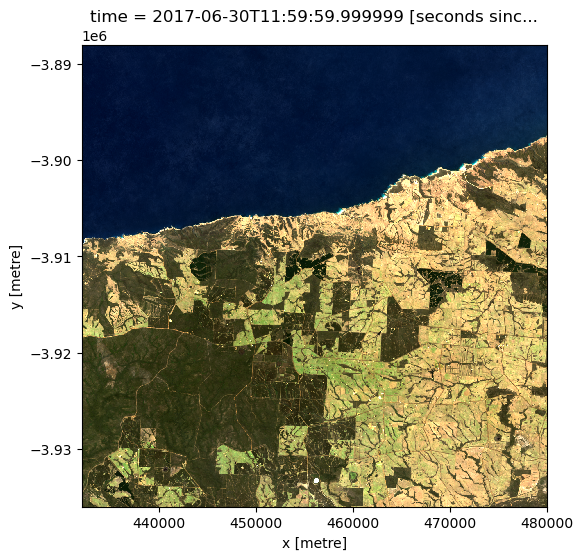

In [7]:
#check the loaded area by plotting it
rgb(geomed_ds.isel(x=range(1600, 3200), y=range(1600, 3200)), bands=["red", "green", "blue"], index=0)

In [8]:
# only keep the bottom-right area to save processing cost, and convert it to Numpy Data Array
geomed_ds = geomed_ds[["red", "green", "blue", "nir", "swir1", "swir2"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='geomedian').geomedian

In [9]:
%%time

pre_fire_ard = dea_tools.datahandling.load_ard(dc, 
                                               products=['ga_ls8c_ard_3'],
                                               measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1", "nbart_swir_2"],
                                               dask_chunks={}, 
                                               geopolygon=pgon, 
                                               output_crs='EPSG:3577', 
                                               resolution=(-30, 30), 
                                               time=("2016-07-01", "2019-06-30"), 
                                               group_by='solar_day')

Finding datasets
    ga_ls8c_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array
CPU times: user 876 ms, sys: 1.96 ms, total: 878 ms
Wall time: 962 ms


In [10]:
%%time

# only keep the bottom-right area to save processing cost, and convert it to Numpy Data Array
pre_fire_ard = pre_fire_ard[["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1", "nbart_swir_2"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='ard').ard.load()

/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 12min 19s, sys: 1min 53s, total: 14min 13s
Wall time: 3min 48s


## 2. Compute the pre-fire season Outlier layer

### Calculation of geometric median  and cosine and euclidian distances

$\hat{m}: = argmin\sum_{i=1}^{n}\parallel x-x_i\parallel_2$, $x\in \mathbb{R}^p$

The processing involves an iterative optimiser to find a numerical solution. The processing `distances` returns two standardised distances as follows:

The returned variable `cosdistance` is the __cosine distance__ between two spectra, _x_ and _y_, _i.e._, the reflectance time series data and the geometric median reflectance :

$cosdist = 1-\frac{\sum_{i=1}^{p}x_iy_i}{\sqrt{\sum_{i=1}^{p}x_i^2\sum_{i=1}^{p}y_i^2}}$

where _p_ is the number of bands. The denominator is equivalent to the 'spectral angle'.

The returned variable `nbr_eucdistance` is the __Euclidean distance in NBR space__ between the NBR time series and the median NBR (_NBRmed_) calculated from the geometric median:

$NBRdist = \sqrt{\sum_{i=1}^{n}(NBR_i-NBRmed)^2}$

In [11]:
import ctypes
import logging
import multiprocessing as mp
from contextlib import closing

import numpy as np
import pandas as pd
import pyproj
import s3fs
import xarray as xr
from scipy import ndimage
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import unary_union
from skimage import measure

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s")


def cos_distance(ref, obs):
    """
    Returns the cosine distance between observation and reference
    The calculation is point based, easily adaptable to any dimension.
    Args:
        ref: reference (1-D array with multiple bands) e.g., geomatrix median [Nbands]
        obs: observation (with multiple bands, e.g. 6) e.g.,  monthly geomatrix median or reflectance [Nbands,ndays]

    Returns:
        cosdist: the cosine distance at each time step in [ndays]
    """
    ref = ref.astype(np.float32)[:, np.newaxis]
    obs = obs.astype(np.float32)
    cosdist = np.empty((obs.shape[1],))
    cosdist.fill(np.nan)

    cosdist = np.transpose(
        1
        - np.nansum(ref * obs, axis=0)
        / np.sqrt(np.sum(ref**2))
        / np.sqrt(np.nansum(obs**2, axis=0))
    )
    return cosdist


def nbr_eucdistance(ref, obs):
    """
    Returns the euclidean distance between the NBR at each time step with the NBR calculated from the geometric medians
    and also the direction of change to the NBR from the geometric medians.

    Args:
        ref: NBR calculated from geometric median, one value
        obs: NBR time series, 1-D time series array with ndays

    Returns:
        nbr_dist: the euclidean distance
        direction: change direction (1: decrease; 0: increase) at each time step in [ndays]
    """
    nbr_dist = np.empty((obs.shape[0],))
    direction = np.zeros((obs.shape[0],), dtype="uint8")
    nbr_dist.fill(np.nan)
    index = np.where(~np.isnan(obs))[0]
    euc_dist = obs[index] - ref
    euc_norm = np.sqrt(euc_dist**2)
    nbr_dist[index] = euc_norm
    direction[index[euc_dist < -0.05]] = 1

    return nbr_dist, direction


def dist_distance(params):
    """
    multiprocess version with shared memory of the cosine distances and nbr distances
    """
    ard = np.frombuffer(shared_in_arr1.get_obj(), dtype=np.int16).reshape(params[2])
    gmed = np.frombuffer(shared_in_arr2.get_obj(), dtype=np.float32).reshape(
        (params[2][0], params[2][2])
    )
    cos_dist = np.frombuffer(shared_out_arr1.get_obj(), dtype=np.float32).reshape(
        (params[2][1], params[2][2])
    )
    nbr_dist = np.frombuffer(shared_out_arr2.get_obj(), dtype=np.float32).reshape(
        (params[2][1], params[2][2])
    )
    direction = np.frombuffer(shared_out_arr3.get_obj(), dtype=np.int16).reshape(
        (params[2][1], params[2][2])
    )

    for i in range(params[0], params[1]):
        ind = np.where(ard[1, :, i] > 0)[0]  # 7 bands setting
        # ind = np.where(ard[0, :, i] > 0)[0] # 3 bands setting

        if len(ind) > 0:
            cos_dist[ind, i] = cos_distance(gmed[:, i], ard[:, ind, i])
            # 7 bands setting
            nbrmed = (gmed[3, i] - gmed[5, i]) / (gmed[3, i] + gmed[5, i])
            nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])

            # 3 bands setting
            # nbrmed = (gmed[1, i] - gmed[2, i]) / (gmed[1, i] + gmed[2, i])
            # nbr = (ard[1, :, i] - ard[2, :, i]) / (ard[1, :, i] + ard[2, :, i])
            nbr_dist[ind, i], direction[ind, i] = nbr_eucdistance(nbrmed, nbr[ind])


def distances(ard, geomed, n_procs=1):
    """
    Calculates the cosine distance between observation and reference.
    The calculation is point based, easily adaptable to any dimension.
        Note:
            This method saves the result of the computation into the
            dists variable: p-dimensional vector with geometric
            median reflectances, where p is the number of bands.
        Args:
            ard: load from ODC
            geomed: load from odc-stats GeoMAD plugin result
            n_procs: tolerance criterion to stop iteration
    """

    n = len(ard.y) * len(ard.x)
    _x = ard

    t_dim = _x.time.data
    if len(t_dim) < 1:
        logger.warning(f"--- {len(t_dim)} observations")
        return

    # 7 bands setting
    nir = _x[3, :, :, :].data.astype("float32")
    swir2 = _x[5, :, :, :].data.astype("float32")

    # 3 bands setting
    # nir = _x[1, :, :, :].data.astype("float32")
    # swir2 = _x[2, :, :, :].data.astype("float32")

    nir[nir <= 0] = np.nan
    swir2[swir2 <= 0] = np.nan
    nbr = (nir - swir2) / (nir + swir2)

    out_arr1 = mp.Array(ctypes.c_float, len(t_dim) * n)
    out_arr2 = mp.Array(ctypes.c_float, len(t_dim) * n)
    out_arr3 = mp.Array(ctypes.c_short, len(t_dim) * n)

    cos_dist = np.frombuffer(out_arr1.get_obj(), dtype=np.float32).reshape(
        (len(t_dim), n)
    )
    cos_dist.fill(np.nan)
    nbr_dist = np.frombuffer(out_arr2.get_obj(), dtype=np.float32).reshape(
        (len(t_dim), n)
    )
    nbr_dist.fill(np.nan)
    direction = np.frombuffer(out_arr3.get_obj(), dtype=np.int16).reshape(
        (len(t_dim), n)
    )
    direction.fill(0)

    in_arr1 = mp.Array(ctypes.c_short, len(ard.band) * len(_x.time) * n)
    x = np.frombuffer(in_arr1.get_obj(), dtype=np.int16).reshape(
        (len(ard.band), len(_x.time), n)
    )
    x[:] = _x.data.reshape(len(ard.band), len(_x.time), -1)

    in_arr2 = mp.Array(ctypes.c_float, len(ard.band) * n)
    gmed = np.frombuffer(in_arr2.get_obj(), dtype=np.float32).reshape(
        (len(ard.band), n)
    )
    gmed[:] = geomed.data.reshape(len(ard.band), -1)

    def init(
        shared_in_arr1_,
        shared_in_arr2_,
        shared_out_arr1_,
        shared_out_arr2_,
        shared_out_arr3_,
    ):
        global shared_in_arr1
        global shared_in_arr2
        global shared_out_arr1
        global shared_out_arr2
        global shared_out_arr3

        shared_in_arr1 = shared_in_arr1_
        shared_in_arr2 = shared_in_arr2_
        shared_out_arr1 = shared_out_arr1_
        shared_out_arr2 = shared_out_arr2_
        shared_out_arr3 = shared_out_arr3_

    with closing(
        mp.Pool(
            initializer=init,
            initargs=(
                in_arr1,
                in_arr2,
                out_arr1,
                out_arr2,
                out_arr3,
            ),
            processes=n_procs,
        )
    ) as p:
        chunk = 1
        if n == 0:
            logger.warning("no point")
            return
        p.map_async(
            dist_distance,
            [(i, min(n, i + chunk), x.shape) for i in range(0, n, chunk)],
        )

    p.join()

    ds = xr.Dataset(
        coords={
            "time": t_dim,
            "y": ard.y[:],
            "x": ard.x[:],
            "band": ard.band,
        },
        attrs={"crs": "EPSG:3577"},
    )

    ds["CDist"] = (
        ("time", "y", "x"),
        cos_dist[:].reshape((len(t_dim), len(ard.y), len(ard.x))).astype("float32"),
    )
    ds["NBRDist"] = (
        ("time", "y", "x"),
        nbr_dist[:].reshape((len(t_dim), len(ard.y), len(ard.x))).astype("float32"),
    )
    ds["ChangeDir"] = (
        ("time", "y", "x"),
        direction[:].reshape((len(t_dim), len(ard.y), len(ard.x))).astype("float32"),
    )
    ds["NBR"] = (("time", "y", "x"), nbr)

    del (
        in_arr1,
        in_arr2,
        out_arr1,
        out_arr2,
        out_arr3,
        gmed,
        ard,
        cos_dist,
        nbr_dist,
        direction,
        nbr,
    )

    return ds

In [12]:
%%time

pre_fire_dis = distances(pre_fire_ard, geomed_ds)

CPU times: user 7.77 s, sys: 7.35 s, total: 15.1 s
Wall time: 4min 50s


### Outlier mapping
Having calculated the cosine and NBR euclidian distance, we can calculate a distance _d_ for every pixel that corresponds to the threshold distance for an outlier. 
We the use quartile-based outlier criterion commonly used in box-and-whiskers plots, among others (Tukey, 1977): 

$ d > Q_{3}+1.5*{IQR} = Q_{3}+1.5(Q_{3}-Q_{1})$

where $Q_1$ and $Q_3$ are the 1st and 3rd quartile (or 25th and 75th percentile), and _IQR_ is the interquartile range.  


In [13]:
def _zvalue_from_index(arr, ind):
    """
    private helper function to work around the limitation of np.choose() by employing np.take()
    arr has to be a 3D array
    ind has to be a 2D array containing values for z-indicies to take from arr
    modified from https://krstn.eu/np.nanpercentile()-there-has-to-be-a-faster-way/
    with order of nR and nC fixed.
    """
    # get number of columns and rows
    _, nr, nc = arr.shape

    # get linear indices and extract elements with np.take()
    idx = nr * nc * ind + nc * np.arange(nr)[:, np.newaxis] + np.arange(nc)
    return np.take(arr, idx)

def nanpercentile(inarr, q):
    """
    faster nanpercentile than np.nanpercentile for axis 0 of a 3D array.
    modified from https://krstn.eu/np.nanpercentile()-there-has-to-be-a-faster-way/
    """
    arr = inarr.copy()
    # valid (non NaN) observations along the first axis
    valid_obs = np.isfinite(arr).sum(axis=0)
    # replace NaN with maximum
    max_val = np.nanmax(arr)
    arr[np.isnan(arr)] = max_val
    # sort - former NaNs will move to the end
    arr.sort(axis=0)

    # loop over requested quantiles
    if type(q) is list:
        qs = q
    else:
        qs = [q]
    quant_arrs = np.empty(shape=(len(qs), arr.shape[1], arr.shape[2]))
    quant_arrs.fill(np.nan)

    for i in range(len(qs)):
        quant = qs[i]
        # desired position as well as floor and ceiling of it
        k_arr = (valid_obs - 1) * (quant / 100.0)
        f_arr = np.floor(k_arr).astype(np.int32)
        c_arr = np.ceil(k_arr).astype(np.int32)
        fc_equal_k_mask = f_arr == c_arr

        # linear interpolation (like numpy percentile) takes the fractional part of desired position
        floor_val = _zvalue_from_index(arr, f_arr) * (c_arr - k_arr)
        ceil_val = _zvalue_from_index(arr, c_arr) * (k_arr - f_arr)

        quant_arr = floor_val + ceil_val
        quant_arr[fc_equal_k_mask] = _zvalue_from_index(arr, f_arr)[fc_equal_k_mask]

        quant_arrs[i] = quant_arr

    if quant_arrs.shape[0] == 1:
        return np.squeeze(quant_arrs, axis=0)
    else:
        return quant_arrs

def outliers(dataset, distances):
    """
    Calculate the outliers for distances for change detection
    """
    logger.info("begin to process outlier")

    if distances is None:
        logger.warning("no distances for the outlier calculations")
        return
    nbr_ps = nanpercentile(distances.NBRDist.data, [25, 75])

    nbr_outlier = nbr_ps[1] + 1.5 * (nbr_ps[1] - nbr_ps[0])
    cos_distps = nanpercentile(distances.CDist.data, [25, 75])
    cos_dist_outlier = cos_distps[1] + 1.5 * (cos_distps[1] - cos_distps[0])

    ds = xr.Dataset(
        coords={"y": dataset.y[:], "x": dataset.x[:]}, attrs={"crs": "EPSG:3577"}
    )
    ds["CDistoutlier"] = (("y", "x"), cos_dist_outlier.astype("float32"))
    ds["NBRoutlier"] = (("y", "x"), nbr_outlier.astype("float32"))
    return ds

In [14]:
%%time

outliers_result = outliers(pre_fire_ard, pre_fire_dis)

2023-07-31 05:52:55,891 begin to process outlier


CPU times: user 9.73 s, sys: 183 ms, total: 9.91 s
Wall time: 9.91 s


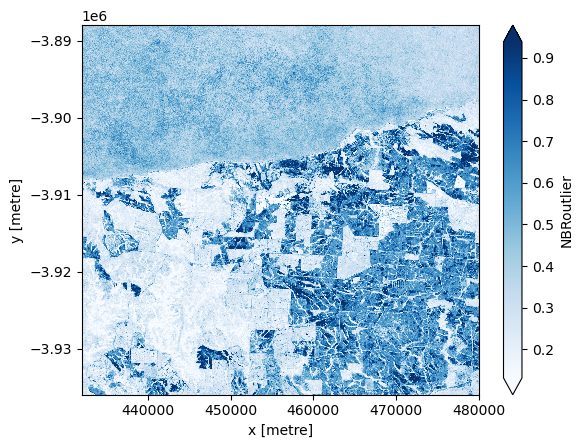

In [15]:
outliers_result.NBRoutlier.plot.imshow(robust=True,cmap='Blues')

## 3. Loading the pre-fire season data

Use `load_ard` to load fire season ARD data.

In [16]:
%%time

fire_season_ard = dea_tools.datahandling.load_ard(dc, 
                                               products=['ga_ls8c_ard_3'],
                                               measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1", "nbart_swir_2"],
                                               dask_chunks={}, 
                                               geopolygon=pgon, 
                                               output_crs='EPSG:3577', 
                                               resolution=(-30, 30), 
                                               time=("2019-07-01", "2020-06-30"), 
                                               group_by='solar_day')


Finding datasets
    ga_ls8c_ard_3
Applying fmask pixel quality/cloud mask
Returning 46 time steps as a dask array
CPU times: user 271 ms, sys: 25.7 ms, total: 297 ms
Wall time: 328 ms


In [17]:
%%time

fire_season_ard = fire_season_ard[["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1", "nbart_swir_2"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='cube')["cube"].load()

CPU times: user 4min 12s, sys: 35.9 s, total: 4min 48s
Wall time: 1min 18s


## 4. Detects burnt area by using outliers and NBR euclidean distance and filter by DEA Hotsop

### compute the distance between fire season ARD data and pre-fire GeoMedian data.

In [18]:
%%time

fire_season_distance = distances(fire_season_ard, geomed_ds)

CPU times: user 4.74 s, sys: 2.61 s, total: 7.34 s
Wall time: 4min 20s


In [19]:
# download from: https://ga-sentinel.s3-ap-southeast-2.amazonaws.com/historic/all-data-csv.zip
hotspotfile = "hotspot_historic.csv"

In [20]:
def dist_severity(params):
    """
    multiprocess version with shared memory of the severity algorithm
    """

    nbr = np.frombuffer(shared_in_arr01.get_obj(), dtype=np.float32).reshape(
        (-1, params[2])
    )
    nbr_dist = np.frombuffer(shared_in_arr02.get_obj(), dtype=np.float32).reshape(
        (-1, params[2])
    )
    c_dist = np.frombuffer(shared_in_arr03.get_obj(), dtype=np.float32).reshape(
        (-1, params[2])
    )
    change_dir = np.frombuffer(shared_in_arr04.get_obj(), dtype=np.int16).reshape(
        (-1, params[2])
    )
    nbr_outlier = np.frombuffer(shared_in_arr05.get_obj(), dtype=np.float32)
    cdist_outlier = np.frombuffer(shared_in_arr06.get_obj(), dtype=np.float32)
    t = np.frombuffer(shared_in_arr07.get_obj(), dtype=np.float64)

    sev = np.frombuffer(shared_out_arr01.get_obj(), dtype=np.float64)
    dates = np.frombuffer(shared_out_arr02.get_obj(), dtype=np.float64)
    days = np.frombuffer(shared_out_arr03.get_obj(), dtype=np.float64)

    for i in range(params[0], params[1]):
        sev[i], dates[i], days[i] = severity(
            nbr[:, i],
            nbr_dist[:, i],
            c_dist[:, i],
            change_dir[:, i],
            nbr_outlier[i],
            cdist_outlier[i],
            t,
            method=params[3],
        )


def severity(
    nbr,
    nbr_dist,
    cos_dist,
    change_dir,
    nbr_outlier,
    cos_dist_outlier,
    t,
    method="NBRdist",
):
    """
    Returns the severity,duration and start date of the change.
    Args:
        nbr: normalised burn ratio in tx1 dimension
        nbr_dist: nbr distance in tx1 dimension
        cos_dist: cosine distance in tx1 dimension
        change_dir: NBR change direction in tx1 dimension
        nbr_outlier: outlier values for NBRdist
        cos_dist_outlier: outlier values for CDist
        t: dates of observations
        data: xarray including the cosine distances, NBR distances, NBR, change direction and outliers value
        method: two options to choose
            NBR: use cosine distance together with NBR<0
            NBRdist: use both cosine distance, NBR euclidean distance, and NBR change direction for change detection

    Returns:
        sevindex: severity
        startdate: first date change was detected
        duration: duration between the first and last date the change exceeded the outlier threshold
    """

    sevindex = 0
    startdate = 0
    duration = 0

    notnanind = np.where(~np.isnan(cos_dist))[0]  # remove the nan values for each pixel

    if method == "NBR":  # cosdist above the line and NBR<0
        outlierind = np.where(
            (cos_dist[notnanind] > cos_dist_outlier) & (nbr[notnanind] < 0)
        )[0]
        cosdist = cos_dist[notnanind]

    elif (
        method == "NBRdist"
    ):  # both cosdist and NBR dist above the line and it is negative change
        outlierind = np.where(
            (cos_dist[notnanind] > cos_dist_outlier)
            & (nbr_dist[notnanind] > nbr_outlier)
            & (change_dir[notnanind] == 1)
        )[0]

        cosdist = cos_dist[notnanind]
    else:
        raise ValueError
    t = t.astype("datetime64[ns]")
    t = t[notnanind]
    outlierdates = t[outlierind]
    n_out = len(outlierind)
    area_above_d0 = 0
    if n_out >= 2:
        tt = []
        for ii in range(0, n_out):
            if outlierind[ii] + 1 < len(t):
                u = np.where(t[outlierind[ii] + 1] == outlierdates)[
                    0
                ]  # next day have to be outlier to be included
                # print(u)

                if len(u) > 0:
                    t1_t0 = (
                        (t[outlierind[ii] + 1] - t[outlierind[ii]])
                        / np.timedelta64(1, "s")
                        / (60 * 60 * 24)
                    )
                    y1_y0 = (
                        cosdist[outlierind[ii] + 1] + cosdist[outlierind[ii]]
                    ) - 2 * cos_dist_outlier
                    area_above_d0 = (
                        area_above_d0 + 0.5 * y1_y0 * t1_t0
                    )  # calculate the area under the curve
                    duration = duration + t1_t0
                    tt.append(ii)  # record the index where it is detected as a change

        if len(tt) > 0:
            startdate = t[outlierind[tt[0]]]  # record the date of the first change
            sevindex = area_above_d0

    return sevindex, startdate, duration


def outline_to_mask(line, x, y):
    """Create mask from outline contour

    Parameters
    ----------
    line: array-like (N, 2)
    x, y: 1-D grid coordinates (input for meshgrid)

    Returns
    -------
    mask : 2-D boolean array (True inside)

    Examples
    --------
    >>> from shapely.geometry import Point
    >>> poly = Point(0, 0).buffer(1)
    >>> x = np.linspace(-5, 5, 100)
    >>> y = np.linspace(-5, 5, 100)
    >>> mask = outline_to_mask(poly.boundary, x, y)
    """
    import matplotlib.path as mplp

    mpath = mplp.Path(line)
    x_val, y_val = np.meshgrid(x, y)
    points = np.array((x_val.flatten(), y_val.flatten())).T
    mask = mpath.contains_points(points).reshape(x_val.shape)

    return mask


def post_filtering(sev, hotspots_filtering=True, date_filtering=True):
    """
    This function cleans up the potential cloud contaminated results with hotspots data and start date
    variables:
        sev: outputs from BurnCube
        hotspots_filtering: whether filtering the results with hotspots data
        date_filtering: whether filtering the results with only five major changes with startdate info
    outputs:
        sev: with one extra layer 'cleaned'
    """
    if "Moderate" in sev.keys():
        burn_pixel = (
            sev.Moderate
        ) 
        filtered_burnscar = np.zeros(burn_pixel.data.shape).astype("f4")

        if hotspots_filtering:

            all_labels = measure.label(burn_pixel.data, background=0)

            if ("Corroborate" in sev.keys()) * (sev.Corroborate.data.sum() > 0):
                hs_pixel = sev.Corroborate  
                tmp = all_labels * hs_pixel.data.astype("int32")
                overlappix = (-hs_pixel.data + burn_pixel.data * 2).reshape(-1)
                if len(overlappix[overlappix == 2]) > 0:
                    overlaplabels = np.unique(tmp)
                    labels = overlaplabels[overlaplabels > 0]
                    for i in labels:
                        seg = np.zeros(burn_pixel.data.shape)
                        seg[all_labels == i] = 1
                        if np.sum(seg * hs_pixel.data) > 0:
                            filtered_burnscar[seg == 1] = 1
                else:
                    filtered_burnscar[:] = burn_pixel.data.copy()

            else:
                filtered_burnscar = np.zeros(burn_pixel.data.shape)

            cleaned = np.zeros(burn_pixel.data.shape)
            filtered_burnscar[filtered_burnscar == 0] = np.nan
            clean_date = filtered_burnscar * sev.StartDate
            mask = np.where(~np.isnan(clean_date.data))
            clean_date = clean_date.astype("datetime64[ns]")
            cleaned[mask[0], mask[1]] = pd.DatetimeIndex(
                clean_date.data[mask[0], mask[1]]
            ).month
            sev["Cleaned"] = (("y", "x"), cleaned.astype("int16"))

        if date_filtering:
            hotspotsmask = burn_pixel.data.copy().astype("float32")
            hotspotsmask[hotspotsmask == 0] = np.nan
            firedates = (sev.StartDate.data * hotspotsmask).reshape(-1)
            values, counts = np.unique(
                firedates[~np.isnan(firedates)], return_counts=True
            )
            sortcounts = np.array(sorted(counts, reverse=True))
            datemask = np.zeros(sev.StartDate.data.shape)
            hp_masked_date = sev.StartDate * hotspotsmask.copy()
            # print(len(sortcounts))
            if len(sortcounts) <= 2:
                fireevents = sortcounts[0:1]
            else:
                fireevents = sortcounts[0:5]

            for fire in fireevents:
                # print('Change detected at: ',values[counts==fire].astype('datetime64[ns]')[0])
                firedate = values[counts == fire]

                for firei in firedate:
                    start = (
                        firei.astype("datetime64[ns]") - np.datetime64(1, "M")
                    ).astype("datetime64[ns]")
                    end = (
                        firei.astype("datetime64[ns]") - np.datetime64(-1, "M")
                    ).astype("datetime64[ns]")

                    row, col = np.where(
                        (hp_masked_date.data.astype("datetime64[ns]") >= start)
                        & (hp_masked_date.data.astype("datetime64[ns]") <= end)
                    )

                    datemask[row, col] = 1

            # burn_pixel.data = burn_pixel.data*datemask
            filtered_burnscar = burn_pixel.data.astype("float32").copy()
            filtered_burnscar = filtered_burnscar * datemask
            filtered_burnscar[filtered_burnscar == 0] = np.nan
            cleaned = np.zeros(burn_pixel.data.shape)
            clean_date = filtered_burnscar * sev.StartDate.data
            mask = np.where(~np.isnan(clean_date))
            clean_date = clean_date.astype("datetime64[ns]")
            cleaned[mask[0], mask[1]] = pd.DatetimeIndex(
                clean_date[mask[0], mask[1]]
            ).month
            sev["Cleaned"] = (("y", "x"), cleaned.astype("int16"))

    return sev


def severitymapping(
    dists,
    outlrs,
    period,
    hotspotfile,
    method="NBR",
    growing=True,
    hotspots_period=None,
    n_procs=1,
):
    """Calculates burnt area for a given period
    Args:
        period: period of time with burn mapping interest,  e.g.('2015-01-01','2015-12-31')
        n_procs: tolerance criterion to stop iteration
        method: methods for change detection
        growing: whether to grow the region
    """

    if dists is None:
        logger.warning("no data available for severity mapping")
        return None

    c_dist = dists.CDist.data.reshape((len(dists.time), -1))
    cdist_outlier = outlrs.CDistoutlier.data.reshape(len(dists.x) * len(dists.y))
    nbr_dist = dists.NBRDist.data.reshape((len(dists.time), -1))
    nbr = dists.NBR.data.reshape((len(dists.time), -1))
    nbr_outlier = outlrs.NBRoutlier.data.reshape(len(dists.x) * len(dists.y))
    change_dir = dists.ChangeDir.data.reshape((len(dists.time), -1))

    if method == "NBR":
        tmp = (
            dists.CDist.where((dists.CDist > outlrs.CDistoutlier) & (dists.NBR < 0))
            .sum(axis=0)
            .data
        )
        tmp = tmp.reshape(len(dists.x) * len(dists.y))
        outlierind = np.where(tmp > 0)[0]

    elif method == "NBRdist":
        tmp = (
            dists.CDist.where(
                (dists.CDist > outlrs.CDistoutlier)
                & (dists.NBRDist > outlrs.NBRoutlier)
                & (dists.ChangeDir == 1)
            )
            .sum(axis=0)
            .data
        )
        tmp = tmp.reshape(len(dists.x) * len(dists.y))
        outlierind = np.where(tmp > 0)[0]

    else:
        raise ValueError

    if len(outlierind) == 0:
        logger.warning("no burnt area detected")
        return None
    # input shared arrays
    in_arr1 = mp.Array(ctypes.c_float, len(dists.time[:]) * len(outlierind))
    nbr_shared = np.frombuffer(in_arr1.get_obj(), dtype=np.float32).reshape(
        (len(dists.time[:]), len(outlierind))
    )
    nbr_shared[:] = nbr[:, outlierind]

    in_arr2 = mp.Array(ctypes.c_float, len(dists.time[:]) * len(outlierind))
    nbr_dist_shared = np.frombuffer(in_arr2.get_obj(), dtype=np.float32).reshape(
        (len(dists.time[:]), len(outlierind))
    )
    nbr_dist_shared[:] = nbr_dist[:, outlierind]

    in_arr3 = mp.Array(ctypes.c_float, len(dists.time[:]) * len(outlierind))
    cosdist_shared = np.frombuffer(in_arr3.get_obj(), dtype=np.float32).reshape(
        (len(dists.time[:]), len(outlierind))
    )
    cosdist_shared[:] = c_dist[:, outlierind]

    in_arr4 = mp.Array(ctypes.c_short, len(dists.time[:]) * len(outlierind))
    change_dir_shared = np.frombuffer(in_arr4.get_obj(), dtype=np.int16).reshape(
        (len(dists.time[:]), len(outlierind))
    )
    change_dir_shared[:] = change_dir[:, outlierind]

    in_arr5 = mp.Array(ctypes.c_float, len(outlierind))
    nbr_outlier_shared = np.frombuffer(in_arr5.get_obj(), dtype=np.float32)
    nbr_outlier_shared[:] = nbr_outlier[outlierind]

    in_arr6 = mp.Array(ctypes.c_float, len(outlierind))
    cdist_outlier_shared = np.frombuffer(in_arr6.get_obj(), dtype=np.float32)
    cdist_outlier_shared[:] = cdist_outlier[outlierind]

    in_arr7 = mp.Array(ctypes.c_double, len(dists.time[:]))
    t = np.frombuffer(in_arr7.get_obj(), dtype=np.float64)
    t[:] = dists.time.data.astype("float64")

    # output shared arrays
    out_arr1 = mp.Array(ctypes.c_double, len(outlierind))
    sev = np.frombuffer(out_arr1.get_obj(), dtype=np.float64)
    sev.fill(np.nan)

    out_arr2 = mp.Array(ctypes.c_double, len(outlierind))
    dates = np.frombuffer(out_arr2.get_obj(), dtype=np.float64)
    dates.fill(np.nan)

    out_arr3 = mp.Array(ctypes.c_double, len(outlierind))
    days = np.frombuffer(out_arr3.get_obj(), dtype=np.float64)
    days.fill(0)

    def init(
        shared_in_arr1_,
        shared_in_arr2_,
        shared_in_arr3_,
        shared_in_arr4_,
        shared_in_arr5_,
        shared_in_arr6_,
        shared_in_arr7_,
        shared_out_arr1_,
        shared_out_arr2_,
        shared_out_arr3_,
    ):
        global shared_in_arr01
        global shared_in_arr02
        global shared_in_arr03
        global shared_in_arr04
        global shared_in_arr05
        global shared_in_arr06
        global shared_in_arr07
        global shared_out_arr01
        global shared_out_arr02
        global shared_out_arr03

        shared_in_arr01 = shared_in_arr1_
        shared_in_arr02 = shared_in_arr2_
        shared_in_arr03 = shared_in_arr3_
        shared_in_arr04 = shared_in_arr4_
        shared_in_arr05 = shared_in_arr5_
        shared_in_arr06 = shared_in_arr6_
        shared_in_arr07 = shared_in_arr7_
        shared_out_arr01 = shared_out_arr1_
        shared_out_arr02 = shared_out_arr2_
        shared_out_arr03 = shared_out_arr3_

    with closing(
        mp.Pool(
            initializer=init,
            initargs=(
                in_arr1,
                in_arr2,
                in_arr3,
                in_arr4,
                in_arr5,
                in_arr6,
                in_arr7,
                out_arr1,
                out_arr2,
                out_arr3,
            ),
            processes=n_procs,
        )
    ) as p:
        chunk = 1
        if len(outlierind) == 0:
            return
        p.map_async(
            dist_severity,
            [
                (i, min(len(outlierind), i + chunk), len(outlierind), method)
                for i in range(0, len(outlierind), chunk)
            ],
        )

    p.join()

    sevindex = np.zeros(len(dists.y) * len(dists.x))
    duration = np.zeros(len(dists.y) * len(dists.x)) * np.nan
    startdate = np.zeros(len(dists.y) * len(dists.x)) * np.nan
    sevindex[outlierind] = sev
    duration[outlierind] = days
    startdate[outlierind] = dates
    sevindex = sevindex.reshape((len(dists.y), len(dists.x)))
    duration = duration.reshape((len(dists.y), len(dists.x)))
    startdate = startdate.reshape((len(dists.y), len(dists.x)))
    startdate[startdate == 0] = np.nan
    duration[duration == 0] = np.nan
    del (
        in_arr1,
        in_arr2,
        in_arr3,
        in_arr4,
        in_arr5,
        in_arr6,
        out_arr1,
        out_arr2,
        out_arr3,
    )
    del (
        sev,
        days,
        dates,
        nbr_shared,
        nbr_dist_shared,
        cosdist_shared,
        nbr_outlier_shared,
        change_dir_shared,
        cdist_outlier_shared,
    )

    out = xr.Dataset(coords={"y": dists.y[:], "x": dists.x[:]})
    out["StartDate"] = (("y", "x"), startdate)
    out["Duration"] = (("y", "x"), duration.astype("int16"))
    burnt = np.zeros((len(dists.y), len(dists.x)))
    burnt[duration > 1] = 1
    out["Severity"] = (("y", "x"), sevindex.astype("float32"))
    out["Severe"] = (("y", "x"), burnt.astype("int16"))

    count = dists["NBR"].count(dim="time").astype("int16")
    out["Count"] = count

    if growing:
        burn_area, growing_dates = region_growing(out, dists, outlrs)
        out["Moderate"] = (("y", "x"), burn_area.astype("int16"))
        growing_dates[growing_dates == 0] = np.nan
        out["StartDate"] = (("y", "x"), growing_dates)

    extent = [
        np.min(dists.x.data),
        np.max(dists.x.data),
        np.min(dists.y.data),
        np.max(dists.y.data),
    ]

    if hotspots_period is None:
        hotspots_period = period
    polygons = hotspot_polygon(
        hotspots_period, extent, 4000, hotspotfile
    )  # generate hotspot polygons with 4km buffer

    # default mask
    hot_spot_mask = np.zeros((len(dists.y), len(dists.x)))

    if polygons is None or polygons.is_empty:
        logger.warning("no hotspots data")
    else:
        coords = out.coords

        if polygons.type == "MultiPolygon":
            for polygon in polygons.geoms:
                hot_spot_mask_tmp = outline_to_mask(
                    polygon.exterior.coords, coords["x"], coords["y"]
                )
                hot_spot_mask = hot_spot_mask_tmp + hot_spot_mask
            hot_spot_mask = xr.DataArray(hot_spot_mask, coords=coords, dims=("y", "x"))
        if polygons.type == "Polygon":
            hot_spot_mask = outline_to_mask(polygons.exterior, coords["x"], coords["y"])
            hot_spot_mask = xr.DataArray(hot_spot_mask, coords=coords, dims=("y", "x"))

        out["Corroborate"] = (("y", "x"), hot_spot_mask.data.astype("int16"))
        out = post_filtering(out, hotspots_filtering=True, date_filtering=False)
    return out

def region_growing(severity, dists, outlrs):
    """
    The function includes further areas that do not qualify as outliers but do show a substantial decrease in NBR and
    are adjoining pixels detected as burns. These pixels are classified as 'moderate severity burns'.
        Note: this function is build inside the 'severity' function
            Args:
                severity: xarray including severity and start-date of the fire
    """
    start_date = severity.StartDate.data[~np.isnan(severity.StartDate.data)].astype(
        "datetime64[ns]"
    )
    change_dates = np.unique(start_date)
    z_distance = 2 / 3  # times outlier distance (eq. 3 stdev)

    # see http://www.scipy-lectures.org/packages/scikit-image/index.html#binary-segmentation-foreground-background
    fraction_seedmap = 0.25  # this much of region must already have been mapped as burnt to be included
    seed_map = (severity.Severe.data > 0).astype(
        int
    )  # use 'Severe' burns as seed map to grow

    start_dates = np.zeros((len(dists.y), len(dists.x)))
    start_dates[~np.isnan(severity.StartDate.data)] = start_date
    tmp_map = seed_map
    annual_map = seed_map
    # grow the region based on StartDate
    for d in change_dates:

        di = str(d)[:10]
        ti = np.where(dists.time > np.datetime64(di))[0][0]
        nbr_score = (dists.ChangeDir * dists.NBRDist)[ti, :, :] / outlrs.NBRoutlier
        cos_score = (dists.ChangeDir * dists.CDist)[ti, :, :] / outlrs.CDistoutlier
        potential = ((nbr_score > z_distance) & (cos_score > z_distance)).astype(int)
        # Use the following line if using NBR is preferred
        # Potential = ((dists.NBR[ti, :, :] > 0) & (cos_score > z_distance)).astype(int)

        all_labels = measure.label(
            potential.astype(int).values, background=0
        )  # labelled all the conneted component
        new_potential = ndimage.mean(seed_map, labels=all_labels, index=all_labels)
        new_potential[all_labels == 0] = 0

        annual_map = annual_map + (new_potential > fraction_seedmap).astype(int)
        annual_map = (annual_map > 0).astype(int)
        start_dates[
            (annual_map - tmp_map) > 0
        ] = d  # assign the same date to the growth region
        tmp_map = annual_map

    burn_extent = annual_map

    return burn_extent, start_dates


def hotspot_polygon(period, extent, buffersize, hotspotfile):
    """Create polygons for the hotspot with a buffer
    year: given year for hotspots data
    extent: [xmin,xmax,ymin,ymax] in crs EPSG:3577
    buffersize: in meters

    Examples:
    ------------
    >>>year=2017
    >>>extent = [1648837.5, 1675812.5, -3671837.5, -3640887.5]
    >>>polygons = hotspot_polygon(year,extent,4000)
    """

    # print("extent", extent)

    # year = int(str(period[0])[0:4])
    # if year >= 2019:
    #    logger.warning("No complete hotspots data after 2018")
    #    return None

    _ = s3fs.S3FileSystem(anon=True)

    # hotspotfile = (
    #    "s3://dea-public-data-dev/projects/burn_cube/ancillary_file/hotspot_historic.csv"
    # )

    # if os.path.isfile(hotspotfile):
    #    column_names = ["datetime", "sensor", "latitude", "longitude"]
    #    table = pd.read_csv(hotspotfile, usecols=column_names)
    # else:
    #    logger.warning("No hotspots file is found")
    #    return None

    column_names = ["datetime", "sensor", "latitude", "longitude"]
    table = pd.read_csv(hotspotfile, usecols=column_names)

    start = (
        np.datetime64(period[0]).astype("datetime64[ns]") - np.datetime64(2, "M")
    ).astype("datetime64[ns]")
    stop = np.datetime64(period[1])
    extent[0] = extent[0] - 100000
    extent[1] = extent[1] + 100000
    extent[2] = extent[2] - 100000
    extent[3] = extent[3] + 100000

    dates = pd.to_datetime(table.datetime.apply(lambda x: x.split("+")[0]).values)

    transformer = pyproj.Transformer.from_crs("EPSG:3577", "EPSG:4283")
    lat, lon = transformer.transform(extent[0:2], extent[2:4])

    index = np.where(
        (table.sensor == "MODIS")
        & (dates >= start)
        & (dates <= stop)
        & (table.latitude <= lat[1])
        & (table.latitude >= lat[0])
        & (table.longitude <= lon[1])
        & (table.longitude >= lon[0])
    )[0]

    latitude = table.latitude.values[index]
    longitude = table.longitude.values[index]

    reverse_transformer = pyproj.Transformer.from_crs("EPSG:4283", "EPSG:3577")
    easting, northing = reverse_transformer.transform(latitude, longitude)

    patch = [
        Point(easting[i], northing[i]).buffer(buffersize) for i in range(0, len(index))
    ]
    polygons = unary_union(patch)

    return polygons

In [21]:
%%time

burn_cube_result = severitymapping(
        fire_season_distance,
        outliers_result,
        ("2019-07-01", "2020-06-30"),
        hotspotfile,
        method="NBRdist",
        growing=True,
    )

CPU times: user 35.4 s, sys: 1.79 s, total: 37.2 s
Wall time: 1min 54s


## 5. Filter result by DEA WOfS summary

### Load WOfS summary data

In [22]:
wofs_summary_ds = dc.load(
        "ga_ls_wo_fq_fyear_3",
        time=("2019-07-01", "2020-06-30"),
        geopolygon=pgon,
        resolution=(-30, 30),
    )

wofs_summary_frequency = wofs_summary_ds.isel(x=range(1600, 3200), y=range(1600, 3200)).frequency

### Filter Burn Cube result by WOfS summary data

In [23]:
def burnpixel_masking(data, varname):
    """
    This function converts the severity map into a burn pixel mask
    Required input:
    data: severity data in 2D, e.g. output from severity_mapping in the changedection.py
    """
    burnpixel = data[varname]
    burnpixel.data[burnpixel.data > 1] = 1
    return burnpixel

# Create a water mask by identifying areas with water frequency greater than or equal to 0.2
water_mask = (wofs_summary_frequency[0, :, :].values >= 0.2).astype(float)

# Create the opposite mask by inverting the boolean values of the water mask
not_water_mask = (~water_mask.astype(bool)).astype(float)

# ocean_mask = generate_ocean_mask(wofs_summary_frequency, region_id)

burnpixel_mod = burnpixel_masking(
    burn_cube_result, "Moderate"
)  # mask the burnt area with "Medium" burnt area
burnpixel_sev = burnpixel_masking(burn_cube_result, "Severe")

wofs_moderate = not_water_mask * burnpixel_mod
wofs_severe = not_water_mask * burnpixel_sev
wofs_severity = not_water_mask * burn_cube_result["Severity"]
wofs_startdate = not_water_mask * burn_cube_result["StartDate"]
wofs_duration = not_water_mask * burn_cube_result["Duration"]
wofs_corroborate = not_water_mask * burn_cube_result["Corroborate"]
wofs_cleaned = not_water_mask * burn_cube_result["Cleaned"]

burn_cube_result = xr.Dataset(
        {
            "StartDate": burn_cube_result["StartDate"],
            "Duration": burn_cube_result["Duration"],
            "Severity": burn_cube_result["Severity"],
            "Severe": burn_cube_result["Severe"],
            "Moderate": burn_cube_result["Moderate"],
            "Corroborate": burn_cube_result["Corroborate"],
            "Cleaned": burn_cube_result["Cleaned"],
            "Count": burn_cube_result["Count"],
            "WOfSModerate": wofs_moderate,
            "WOfSSevere": wofs_severe,
            "WOfSSeverity": wofs_severity,
            "WOfSStartDate": wofs_startdate,
            "WOfSDuration": wofs_duration,
            "WOfSCorroborate": wofs_corroborate,
            "WOfSCleaned": wofs_cleaned,
        }
    )

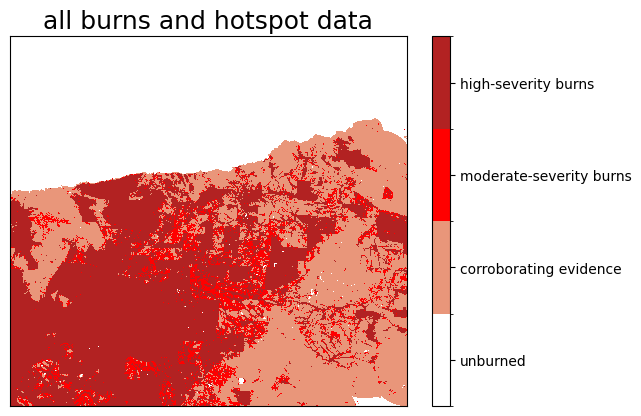

In [24]:
#plot both high and moderate burns with the hotspot data
Allburnt = burn_cube_result.WOfSSevere + burn_cube_result.WOfSModerate + burn_cube_result.WOfSCorroborate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3,4],add_colorbar=False)
cax.axes.set_title('all burns and hotspot data',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['unburned','corroborating evidence','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

# Generate Sentinel 2 Burn Cube result

## 1. Loading the pre-fire season data

Now that we have selected our area of interest (tile) we can load it in. To do this we need to get the polygon that we can then feed into `dc.load` and `load_ard`.

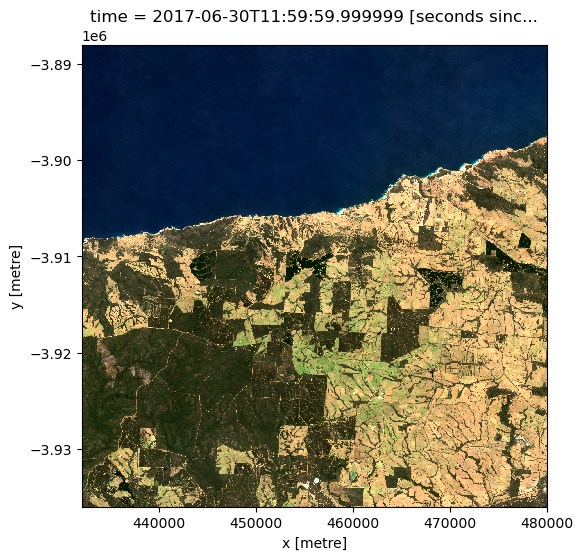

In [25]:
# PRE FIRE DATA
# load in the 4 year geomedian
geomed_ds = hnrs_dc.load(product="ga_s2ab_ard_gm_4fyear_2015", 
                         measurements=["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"], 
                         geopolygon = pgon, 
                         time=("2016-07-01", "2019-06-30"), #financial year
                         output_crs="EPSG:3577")

#check the loaded area by plotting it
rgb(geomed_ds.isel(x=range(1600, 3200), y=range(1600, 3200)), bands=["nbart_red", "nbart_green", "nbart_blue"], index=0)

In [26]:
# only keep the bottom-right area to save processing cost, and convert it to Numpy Data Array
geomed_ds = geomed_ds[["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='geomedian').geomedian

In [ ]:
%%time

pre_fire_ard = dea_tools.datahandling.load_ard(dc, 
                                               products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                                               measurements=["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"],
                                               cloud_mask="s2cloudless",
                                               dask_chunks={}, 
                                               geopolygon=pgon, 
                                               output_crs='EPSG:3577', 
                                               resolution=(-30, 30), 
                                               time=("2016-07-01", "2019-06-30"), 
                                               group_by='solar_day')

# only keep the bottom-right area to save processing cost, and convert it to Numpy Data Array
pre_fire_ard = pre_fire_ard[["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='ard').ard.load()

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Returning 325 time steps as a dask array


## 2. Compute the pre-fire season Outlier layer

In [ ]:
%%time

pre_fire_dis = distances(pre_fire_ard, geomed_ds)

outliers_result = outliers(pre_fire_ard, pre_fire_dis)

In [ ]:
outliers_result.NBRoutlier.plot.imshow(robust=True,cmap='Blues')

## 3. Loading the pre-fire season data

Use `load_ard` to load fire season ARD data.

In [ ]:
%%time

fire_season_ard = dea_tools.datahandling.load_ard(dc, 
                                                  products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                                                  measurements=["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"],
                                                  cloud_mask="s2cloudless",
                                                  dask_chunks={}, 
                                                  geopolygon=pgon, 
                                                  output_crs='EPSG:3577', 
                                                  resolution=(-30, 30), 
                                                  time=("2019-07-01", "2020-06-30"), 
                                                  group_by='solar_day')

fire_season_ard = fire_season_ard[["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"]].isel(x=range(1600, 3200), y=range(1600, 3200)).to_array(dim='band').to_dataset(name='cube')["cube"].load()

## 4. Detects burnt area by using outliers and NBR euclidean distance and filter by DEA Hotsop

In [ ]:
%%time

fire_season_distance = distances(fire_season_ard, geomed_ds)

In [ ]:
%%time

burn_cube_result = severitymapping(
        fire_season_distance,
        outliers_result,
        ("2019-07-01", "2020-06-30"),
        hotspotfile,
        method="NBRdist",
        growing=True,
    )

## 5. Filter result by DEA WOfS summary

In [ ]:
wofs_summary_ds = dc.load(
        "ga_ls_wo_fq_fyear_3", # reuse Landsat WOfS summary result
        time=("2019-07-01", "2020-06-30"),
        geopolygon=pgon,
        resolution=(-30, 30),
    )

wofs_summary_frequency = wofs_summary_ds.isel(x=range(1600, 3200), y=range(1600, 3200)).frequency

In [ ]:
# Create a water mask by identifying areas with water frequency greater than or equal to 0.2
water_mask = (wofs_summary_frequency[0, :, :].values >= 0.2).astype(float)

# Create the opposite mask by inverting the boolean values of the water mask
not_water_mask = (~water_mask.astype(bool)).astype(float)

# ocean_mask = generate_ocean_mask(wofs_summary_frequency, region_id)

burnpixel_mod = burnpixel_masking(
    burn_cube_result, "Moderate"
)  # mask the burnt area with "Medium" burnt area
burnpixel_sev = burnpixel_masking(burn_cube_result, "Severe")

wofs_moderate = not_water_mask * burnpixel_mod
wofs_severe = not_water_mask * burnpixel_sev
wofs_severity = not_water_mask * burn_cube_result["Severity"]
wofs_startdate = not_water_mask * burn_cube_result["StartDate"]
wofs_duration = not_water_mask * burn_cube_result["Duration"]
wofs_corroborate = not_water_mask * burn_cube_result["Corroborate"]
wofs_cleaned = not_water_mask * burn_cube_result["Cleaned"]

burn_cube_result = xr.Dataset(
        {
            "StartDate": burn_cube_result["StartDate"],
            "Duration": burn_cube_result["Duration"],
            "Severity": burn_cube_result["Severity"],
            "Severe": burn_cube_result["Severe"],
            "Moderate": burn_cube_result["Moderate"],
            "Corroborate": burn_cube_result["Corroborate"],
            "Cleaned": burn_cube_result["Cleaned"],
            "Count": burn_cube_result["Count"],
            "WOfSModerate": wofs_moderate,
            "WOfSSevere": wofs_severe,
            "WOfSSeverity": wofs_severity,
            "WOfSStartDate": wofs_startdate,
            "WOfSDuration": wofs_duration,
            "WOfSCorroborate": wofs_corroborate,
            "WOfSCleaned": wofs_cleaned,
        }
    )

In [ ]:
#plot both high and moderate burns with the hotspot data
Allburnt = burn_cube_result.WOfSSevere + burn_cube_result.WOfSModerate + burn_cube_result.WOfSCorroborate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3,4],add_colorbar=False)
cax.axes.set_title('all burns and hotspot data',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['unburned','corroborating evidence','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)